# Imports

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import shutil
import wandb
import matplotlib.pyplot as plt

from wandb.keras import WandbMetricsLogger, WandbCallback

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from keras.layers.normalization.batch_normalization import BatchNormalization
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils.vis_utils import plot_model

from keras import backend as K



# Loading all prediction datasets

In [2]:
koniq10k_directory = '/media/workstation/BackupDrive/Dataset/koniq10k/'
ori_img_dir = koniq10k_directory + 'koniq10k_1024x768_ori/'

# read in scores from koniq_10k
data_mos = pd.read_csv(koniq10k_directory + 'koniq10k_scores_and_distributions/koniq10k_scores_and_distributions.csv')
data_mos_set = pd.read_csv(koniq10k_directory + 'koniq10k_scores_and_distributions/koniq10k_distributions_sets.csv')
set_column = data_mos_set['set']

data_mos['set'] = set_column
display(data_mos)


,image_name,c1,c2,c3,c4,c5,c_total,MOS,SD,MOS_zscore,set
0,10004473376.jpg,0,0,25,73,7,105,3.828571,0.527278,77.383621,training
1,10007357496.jpg,0,3,45,47,1,96,3.479167,0.580003,68.728571,test
2,10007903636.jpg,1,0,20,73,2,96,3.781250,0.527220,78.628571,training
3,10009096245.jpg,0,0,21,75,13,109,3.926606,0.556218,77.243750,training
4,100117038.jpg,0,1,21,72,6,100,3.830000,0.532860,75.112500,training
...,...,...,...,...,...,...,...,...,...,...,...
10068,9984535544.jpg,0,0,46,55,3,104,3.586538,0.550562,70.020089,test
10069,9991658304.jpg,0,1,12,85,6,104,3.923077,0.455651,79.337838,training
10070,9991999836.jpg,0,0,15,79,7,101,3.920792,0.462237,78.092437,test
10071,9995874256.jpg,0,3,53,51,1,108,3.462963,0.570717,68.095133,training


### get the test ImageDataGenerator, for all datasets

In [12]:
# Select the images for training-validation-testing
img_dir = koniq10k_directory + 'koniq10k_512x_image_in_csv/'

data_mos_test = data_mos[data_mos['set'] == 'test']
display(data_mos_test)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


test_generator = test_datagen.flow_from_dataframe(
    dataframe=data_mos_test, 
    directory=img_dir, 
    x_col="image_name", 
    y_col="MOS", 
    shuffle = False,
    class_mode="raw", 
    target_size=(224, 224), 
    batch_size=1
)

,image_name,c1,c2,c3,c4,c5,c_total,MOS,SD,MOS_zscore,set
1,10007357496.jpg,0,3,45,47,1,96,3.479167,0.580003,68.728571,test
9,10020766793.jpg,0,0,11,78,20,109,4.082569,0.529298,81.506250,test
10,10020891105.jpg,0,4,80,18,0,102,3.137255,0.445866,56.829741,test
11,10022757465.jpg,0,3,32,66,4,105,3.676190,0.596387,71.015487,test
18,10039534103.jpg,0,0,34,72,1,107,3.691589,0.483915,76.075000,test
...,...,...,...,...,...,...,...,...,...,...,...
10050,9936084895.jpg,0,5,63,30,0,98,3.255102,0.543210,61.648649,test
10065,9977056676.jpg,0,34,64,5,0,103,2.718447,0.549821,46.301339,test
10066,9977191265.jpg,0,1,44,58,5,108,3.620370,0.591491,74.471698,test
10068,9984535544.jpg,0,0,46,55,3,104,3.586538,0.550562,70.020089,test


Found 2015 validated image filenames.


# Model Prediction (InceptionResNetV2)

### Create the PLCC custom metric first

In [4]:
def plcc_tf(x, y):
    """PLCC metric"""
    xc = x - K.mean(x)
    yc = y - K.mean(y)
    return K.mean(xc*yc)/(K.std(x)*K.std(y) + K.epsilon())

def pearson_correlation(y_true, y_pred):
    # Subtract the mean from true and predicted values
    y_true_mean = K.mean(y_true)
    y_pred_mean = K.mean(y_pred)
    y_true_centered = y_true - y_true_mean
    y_pred_centered = y_pred - y_pred_mean

    # Calculate covariance and standard deviation
    covariance = K.mean(y_true_centered * y_pred_centered)
    y_true_std = K.std(y_true)
    y_pred_std = K.std(y_pred)

    # Calculate Pearson correlation coefficient
    pearson_coefficient = covariance / (y_true_std * y_pred_std + K.epsilon())

    return pearson_coefficient

In [5]:
class CustomMetricCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Calculate the custom metric
        y_true = self.validation_data[1]
        y_pred = self.model.predict(self.validation_data[0])
        pearson_coefficient = pearson_correlation(y_true, y_pred)

        # Log the custom metric using wandb
        wandb.log({"val_pearson_coefficient": pearson_coefficient})

In [7]:
# track hyperparameters 
config={
    "fc1" : 2048,
    "activation1" : 'relu',
    "dropout1": 0.25,
    "fc2" : 1024,
    "activation2" : 'relu',
    "dropout2": 0.25,
    "fc3" : 256,
    "activation3" : 'relu',
    "dropout3": 0.5,
    "fc4" : 1,
    "activation4" : 'linear',
    "dropout4": 0,
    "learning_rate" : 0.001,
    "optimizer": "adam",
    "loss": "mean_squared_error",
    "metric": "root_mean_squared_error",
    "epoch": 35,
    "batch_size": 1
}

In [10]:
# Load the InceptionResNetV2 model without pre-trained weights
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add your own top layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(config['fc1'], activation=config['activation1'])(x)
x = BatchNormalization()(x)
x = Dropout(config['dropout1'])(x)

x = Dense(config['fc2'], activation=config['activation2'])(x)
x = BatchNormalization()(x)
x = Dropout(config['dropout2'])(x)

x = Dense(config['fc3'], activation=config['activation3'])(x)
x = BatchNormalization()(x)
x = Dropout(config['dropout3'])(x)

predictions = Dense(config['fc4'], activation=config['activation4'])(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

optimizer = keras.optimizers.Adam(learning_rate=config['learning_rate'])

# Compile the model
model.compile(optimizer=optimizer,
              loss=config['loss'],
              metrics=[tf.keras.metrics.RootMeanSquaredError(), pearson_correlation]
              )

model.load_weights('/media/workstation/BackupDrive/model/baseline_koniq_quality_likely_eon_32/baseline_koniq_quality_weights_likely_eon_32.h5')


In [14]:
# Predict the model on the preprocessed test data
prediction = model.predict(
    test_generator,
    steps=len(test_generator)
)



In [17]:
import scipy 
from sklearn.metrics import mean_squared_error

def plcc(x, y):
    '''Pearson Linear Correlation Coefficient'''
    x, y = np.float32(x), np.float32(y)
    return scipy.stats.pearsonr(x,y)[0]

def srocc(xs, ys):
    '''Spearman Rank Order Correlation Coefficient'''
    correlation, p_value = scipy.stats.spearmanr(xs, ys)
    return correlation

def rmse(y_test, y_pred):
    mse = np.mean((y_test - y_pred) ** 2)
    return np.sqrt(mse)
    

SRCC/PLCC/RMSE 0.818/0.848/0.298


Text(0.5, 0.98, 'Quality Score Ground truth - Prediction')

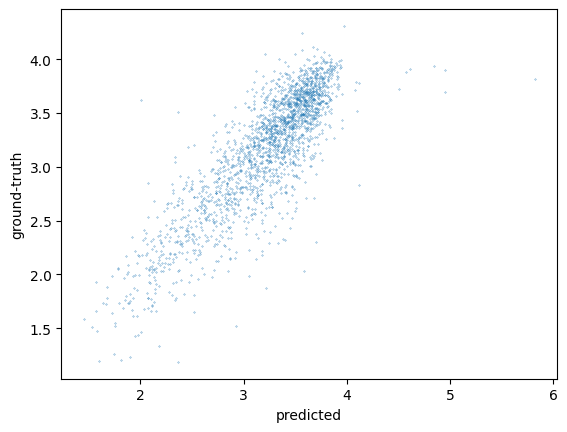

<Figure size 640x480 with 0 Axes>

In [18]:
# prediction
test_list = prediction.tolist()
test_list = [val[0] for val in test_list]
len(test_list)

# data_mos_test
test_1 = data_mos_test.copy()
test_1['pred_value'] = test_list
test_1

y_test = np.array(test_1.loc[:, 'MOS'])
y_pred = np.array(test_1.loc[:, 'pred_value'])

SRCC_test = round(srocc(y_pred, y_test), 3)
PLCC_test = round(plcc(y_pred, y_test), 3)
rmse_test = round(rmse(y_test, y_pred), 3)
print('SRCC/PLCC/RMSE {}/{}/{}'.format(SRCC_test, PLCC_test, rmse_test))

plt.plot(y_pred, y_test, '.', markersize=0.5)
plt.xlabel('predicted'); plt.ylabel('ground-truth'); plt.show
fig = plt.figure()
fig.suptitle('Quality Score Ground truth - Prediction')

In [ ]:
test_1.to_csv('prediction_baseline_koniq_quality_likely_eon_32.csv')